In [81]:
import uproot
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [82]:
#Define global physics parameters
mu_n = -1.9130427
mu_p = 2.792847351
mu_n_simc = -1.913 #truncated precision as it appears in simc code (physics_proton.f)
mu_p_simc = 2.793 #truncated precision as it appears in simc code (physics_proton.f)
M_p = 0.938272
M_n = 0.939565
M_pi = 0.13957

In [83]:
#Define global model parameters
rior_err_fac = 0.097
arr_err_fac = 0.005
ye_t0 = -0.7
GD_range_fac = 0.71

ye_tcut = 4*pow(M_pi,2)

In [84]:
#Define parameters for Riordan, Kelly, Ye, and Arrington07
#In same order, sources:
#simc code
#Kelly Parameterization (https://journals.aps.org/prc/abstract/10.1103/PhysRevC.70.068202)
#Ye, Arrington, Hill, & Lee Parameterization, 2018 (https://doi.org/10.1016/j.physletb.2017.11.023)
#Arrington07 Global Analysis of proton elastic form factor data with tpe corrections (https://journals.aps.org/prc/pdf/10.1103/PhysRevC.76.035205)

# Define S Riordan parameters for GEn
riordan_params = {
    'a_coeffs': [0, 1.52, 2.629, 3.055],
    'b_coeffs': [1, 5.222, 0.04, 11.438],
    'a_err': [0, 0.14744, 0.255013, 0.296335],
    'b_err': [0, 0.506534, 0.00388, 1.109486]
}

# Define JJ Kelly parameters for GEn
kelly_GEn_params = {
    'a_coeffs': [0, 1.7, 0, 0],
    'a_err': [0, 0.04, 0, 0],
    'b_coeffs': [1, 3.3, 0, 0],
    'b_err': [0, 0.32, 0, 0],
}

# Define JJ Kelly parameters for GEp
kelly_GEp_params = {
    'a_coeffs': [1, -0.24, 0, 0],
    'a_err': [0, 0.12, 0, 0],
    'b_coeffs': [1, 10.98, 12.82, 21.97],
    'b_err': [0, 0.19, 1.1, 6.8],
}

# Define JJ Kelly parameters for GMn/mu_n
kelly_GMn_mun_params = {
    'a_coeffs': [1, 2.33, 0, 0],
    'a_err': [0, 1.4, 0, 0],
    'b_coeffs': [1, 14.72, 24.2, 84.1],
    'b_err': [0, 1.7, 9.8, 41],
}

# Define JJ Kelly parameters for GMp/mu_p
kelly_GMp_mup_params = {
    'a_coeffs': [1, 0.12, 0, 0],
    'a_err': [0, 0.04, 0, 0],
    'b_coeffs': [1, 10.97, 18.86, 6.55],
    'b_err': [0, 0.11, 0.28, 1.2],
}

# Define J Arrington 7 parameters for GEp
arrington_7_Gep_params = {
    'a_coeffs': [1, 3.439, -1.602, 0.068],
    'b_coeffs': [1, 15.055, 48.061, 99.304, 0.012, 8.65]
}

# Define J Arrington 7 parameters for GMp
arrington_7_GMp_mup_params = {
    'a_coeffs': [1, -1.465, 1.26, 0.262],
    'b_coeffs': [1, 9.627, 0, 0, 11.179, 13.245]
}

# Define the Ye parameters for GEn
ye_GEn_params = {
    'a_coeffs': [0.048919981, -0.064525054, -0.240825897, 0.392108745, 0.300445259, -0.661888687, -0.17563977, 0.624691724, -0.077684299, -0.236003975, 0.090401973, 0, 0],
    'a_err': [-2.07194073, 1.13809127, 1.01431277, -0.31330138, -0.273293676, 0.257350595, -0.206042113, -0.168497322, 0.137784515, 0.075759196, -0.02675113, -0.017525731, 0.000703582, 0.001479621, 0.000197375]
}

# Define the Ye parameters for GMn/mu_n
ye_GMn_mun_params = {
    'a_coeffs': [0.257758327, -1.079540642, 1.182183812, 0.711015086, -1.348080937, -1.662444025, 2.624354426, 1.751234495, -4.922300879, 3.197892727, -0.71207239, 0, 0],
    'a_err': [-2.06920873, 0.06431564, -0.355593786, 0.41489766, 1.95746824, 0.2705257, -1.52685784, -0.443527359, 0.516884065, 0.207915837, -0.07486657, -0.042541143, 0.00154965, 0.003253223, 0.00042082]
}

# Define the Ye parameters for GEp
ye_GEp_params = {
    'a_coeffs': [0.239163298, -1.109858574, 1.444380813, 0.479569466, -2.286894742, 1.126632985, 1.250619844, -3.631020472, 4.082217024, 0.504097346, -5.085120461, 3.967742544, -0.981529071],
    'a_err': [-1.97750308, -0.446566998, 0.294508717, 1.54467525, 0.905268347, -0.600008111, -1.10732394, -0.098598272, 0.463035988, 0.137729116, -0.078299163, -0.036305693, 0.002642193, 0.003132614, 0.000389594]
}

# Define the Ye parameters for GMp/mu_p
ye_GMp_mup_params = {
    'a_coeffs': [0.264142994, -1.095306122, 1.218553782, 0.661136494, -1.405678925, -1.356418439, 1.447029155, 4.235669736, -5.334045653, -2.916300521, 8.707403068, -5.706999944, 1.280814376],
    'a_err': [-1.76549673, 0.167218457, -1.20542733, -0.472244127, 1.41548871, 0.661320779, -0.816422909, -0.373804477, 0.262223992, 0.128886639, -0.039090151, -0.024499518, 0.00083427, 0.001882264, 0.000243073]
}

In [85]:
# Define the tau and dipole form factor functions
def tau(Q2, M):
    return Q2 / (4 * M**2)

def GD(Q2, GD_fac):
    return (1 + Q2 / GD_fac) ** -2

In [113]:
# Define parameterization functions

# Riordan parameterization for GEn/GD
def riordan_parameterization(tau_n, a_coeffs, b_coeffs):
    num = sum(a * tau_n**k for k, a in enumerate(a_coeffs))  # Sum of a_k * tau_p^k
    den = sum(b * tau_n**k for k, b in enumerate(b_coeffs))  # Sum of b_k * tau_p^k
    return num / den if den != 0 else float('inf')  # Avoid division by zero

# Riordan parameterization error
def riordan_error(tau_n, a_coeffs, a_err, b_coeffs, b_err):
    num = sum(a * tau_n**k for k, a in enumerate(a_coeffs))
    den = sum(b * tau_n**k for k, b in enumerate(b_coeffs))
    
    epsilon = 1e-10
    G = num / (den if den != 0 else epsilon)  # Avoid division by zero

    num_err = np.sqrt(sum(err**2 for err in a_err))  # Calculate errors
    den_err = np.sqrt(sum(err**2 for err in b_err))
    
    num_ratio = (num_err / num) if num != 0 else 0  # Avoid division by zero
    den_ratio = (den_err / den) if den != 0 else 0
    
    one_sig_err = G * np.sqrt(num_ratio**2 + den_ratio**2)
    return one_sig_err

# Riordan simplified error - assume no error in tau
def simplified_riordan_error(G_values, rior_err_fac):
    upper_bands = [G + G * rior_err_fac for G in G_values]
    lower_bands = [G - G * rior_err_fac for G in G_values]
    return upper_bands, lower_bands

# Kelly parameterization for GEn, GEp, GMn, GMp
def kelly_parameterization(tau_value, a_coeffs, b_coeffs):
    num = sum(a * tau_value**k for k, a in enumerate(a_coeffs))
    den = sum(b * tau_value**k for k, b in enumerate(b_coeffs))
    return num / den if den != 0 else float('inf')  # Avoid division by zero

# Kelly parameterization error - needs work
# def kelly_error(tau_value, a_coeffs, a_err, b_coeffs, b_err):
#     num = sum(a * tau_value**k for k, a in enumerate(a_coeffs))
#     den = sum(b * tau_value**k for k, b in enumerate(b_coeffs))
    
#     epsilon = 1e-10
#     G = num / (den if den != 0 else epsilon)  # Avoid division by zero

#     num_err = np.sqrt(sum(err**2 for err in a_err))  # Calculate errors
#     den_err = np.sqrt(sum(err**2 for err in b_err))
    
#     num_ratio = (num_err / num) if num != 0 else 0  # Avoid division by zero
#     den_ratio = (den_err / den) if den != 0 else 0
    
#     one_sig_err = G * np.sqrt(num_ratio**2 + den_ratio**2)
#     return one_sig_err

def kelly_error(tau_value, a_coeffs, a_err, b_coeffs, b_err):
    # Calculate N(x) and D(x)
    num = sum(a * tau_value**k for k, a in enumerate(a_coeffs))
    den = sum(b * tau_value**k for k, b in enumerate(b_coeffs))
    
    epsilon = 1e-10
    G = num / (den if den != 0 else epsilon)  # Calculate G, avoiding division by zero
    
    # Calculate the squared relative errors for the numerator and denominator
    num_squared_relative_errors = sum((err * tau_value**k / num)**2 for k, err in enumerate(a_err) if num != 0)
    den_squared_relative_errors = sum((err * tau_value**k / den)**2 for k, err in enumerate(b_err) if den != 0)
    
    # Total relative error squared in G, considering independent errors in numerator and denominator
    G_squared_relative_error = num_squared_relative_errors + den_squared_relative_errors
    
    # Calculate one sigma error for G
    one_sig_err = G * np.sqrt(G_squared_relative_error)
    
    return one_sig_err

# Kelly simplified error - assume no error in tau
def simplified_kelly_error(tau_values, a_coeffs, a_err, b_coeffs, b_err, G_values):
    # Calculate the total errors in the numerator and denominator using quadrature sum
    num_err_total = np.sqrt(sum(err**2 for err in a_err))
    den_err_total = np.sqrt(sum(err**2 for err in b_err))
    
    # Calculate the numerator and denominator for each tau value
    num_values = [sum(a * tau**k for k, a in enumerate(a_coeffs)) for tau in tau_values]
    den_values = [sum(b * tau**k for k, b in enumerate(b_coeffs)) for tau in tau_values]
    
    # Calculate the error for each G value
    G_errors = [G * np.sqrt((num_err_total / num)**2 + (den_err_total / den)**2) if num != 0 and den != 0 else 0 for G, num, den in zip(G_values, num_values, den_values)]
    
    # Calculate the upper and lower bounds for the error bands
    upper_bands = [G + error for G, error in zip(G_values, G_errors)]
    lower_bands = [G - error for G, error in zip(G_values, G_errors)]
    
    return upper_bands, lower_bands

In [120]:
# Initialize lists to store curve data
GEn_curve_data = []
GMn_curve_data = []
GEp_curve_data = []
GMp_curve_data = []

# Shared Q2 values
Q2_values = np.linspace(0, 12, 600)  # This can be shared among the curves if they have the same Q^2 range

# Shared tau_p values
tau_p_values = [tau(Q2, M_p) for Q2 in Q2_values]

# Shared tau_n values
tau_n_values = [tau(Q2, M_n) for Q2 in Q2_values]

# Riordan fit calculations with simple error
GEn_values_riordan_simple = [riordan_parameterization(tau(Q2, M_n), riordan_params['a_coeffs'], riordan_params['b_coeffs']) for Q2 in Q2_values]
upper_bands_riordan_simple, lower_bands_riordan_simple = simplified_riordan_error(GEn_values_riordan_simple, rior_err_fac) # Implement this function based on your error calculation

GEn_curve_data.append((Q2_values, GEn_values_riordan_simple, upper_bands_riordan_simple, lower_bands_riordan_simple, 'Riordan simple'))

# Riordan fit calculations with parameter error
GEn_values_riordan = []
upper_bands_riordan = []
lower_bands_riordan = []

for Q2 in Q2_values:
    tau_p = tau(Q2, M_n)  # Calculate tau_p for the current Q2 value
    GEn = riordan_parameterization(tau_p, riordan_params['a_coeffs'], riordan_params['b_coeffs'])
    error = riordan_error(tau_p, riordan_params['a_coeffs'], riordan_params['a_err'], riordan_params['b_coeffs'], riordan_params['b_err'])
    
    GEn_values_riordan.append(GEn)
    upper_bands_riordan.append(G + error)
    lower_bands_riordan.append(G - error)

# Convert lists to NumPy arrays for easier manipulation and plotting
GEn_values_riordan = np.array(GEn_values_riordan)
upper_bands_riordan = np.array(upper_bands_riordan)
lower_bands_riordan = np.array(lower_bands_riordan)

#GEn_curve_data.append((Q2_values, GEn_values_riordan, upper_bands_riordan, lower_bands_riordan, 'Riordan detailed'))

# Kelly GEn/GD
kelly_GEn_values = [kelly_parameterization(tau(Q2, M_n), kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs']) for Q2 in Q2_values]
kelly_GEn_over_GD_values = [kelly_parameterization(tau(Q2, M_n), kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs']) / GD(Q2, GD_range_fac) for Q2 in Q2_values]
# kelly_upper_bands_GEn, kelly_lower_bands_GEn = simplified_kelly_error(tau_n_values, kelly_GEn_params['a_coeffs'], kelly_GEn_params['a_err'], kelly_GEn_params['b_coeffs'], kelly_GEn_params['b_err'], kelly_GEn_over_GD_values)
kelly_GEn_errors = [kelly_error(tau(Q2, M_n), kelly_GEn_params['a_coeffs'], kelly_GEn_params['a_err'], kelly_GEn_params['b_coeffs'], kelly_GEn_params['b_err']) for Q2 in Q2_values]
kelly_upper_bands_GEn = [G + error for G, error in zip(GEn_over_GD_values, GEn_errors)]
kelly_lower_bands_GEn = [G - error for G, error in zip(GEn_over_GD_values, GEn_errors)]
GEn_curve_data.append((Q2_values, kelly_GEn_over_GD_values, kelly_upper_bands_GEn, kelly_lower_bands_GEn, 'Kelly GEn/GD'))

# Kelly GEp/GD
kelly_GEp_values = [kelly_parameterization(tau(Q2, M_p), kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs']) for Q2 in Q2_values]
kelly_GEp_over_GD_values = [kelly_parameterization(tau(Q2, M_p), kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs']) / GD(Q2, GD_range_fac) for Q2 in Q2_values]
# kelly_upper_bands_GEp, kelly_lower_bands_GEp = simplified_kelly_error(tau_p_values, kelly_GEp_params['a_coeffs'], kelly_GEp_params['a_err'], kelly_GEp_params['b_coeffs'], kelly_GEp_params['b_err'], kelly_GEp_over_GD_values)

GEp_curve_data = (Q2_values, kelly_GEp_over_GD_values, kelly_upper_bands_GEp, kelly_lower_bands_GEp, 'Kelly GEp/GD')

# Kelly GMn/GD
kelly_GMn_values = [kelly_parameterization(tau(Q2, M_n), kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs']) for Q2 in Q2_values]
kelly_GMn_over_GD_values = [kelly_parameterization(tau(Q2, M_n), kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs']) / GD(Q2, GD_range_fac) for Q2 in Q2_values]
# kelly_upper_bands_GMn, kelly_lower_bands_GMn = simplified_kelly_error(tau_n_values, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['a_err'], kelly_GMn_mun_params['b_coeffs'], kelly_GMn_mun_params['b_err'], kelly_GMn_over_GD_values)

GMn_curve_data = (Q2_values, kelly_GMn_over_GD_values, kelly_upper_bands_GMn, kelly_lower_bands_GMn, 'Kelly GMn/mu_n/GD')

# Kelly GMp/GD
kelly_GMp_values = [kelly_parameterization(tau(Q2, M_p), kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs']) for Q2 in Q2_values]
kelly_GMp_over_GD_values = [kelly_parameterization(tau(Q2, M_p), kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs']) / GD(Q2, GD_range_fac) for Q2 in Q2_values]
# kelly_upper_bands_GMp, kelly_lower_bands_GMp = simplified_kelly_error(tau_p_values, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['a_err'], kelly_GMp_mup_params['b_coeffs'], kelly_GMp_mup_params['b_err'], kelly_GMp_over_GD_values)

GMp_curve_data = (Q2_values, kelly_GMp_over_GD_values, kelly_upper_bands_GMp, kelly_lower_bands_GMp, 'Kelly GMp/mu_p/GD')



In [121]:
def plot_curves(curve_data):
    plt.figure(figsize=(10, 6))
    
    # Define colors for the curves and their error bands
    curve_colors = ['blue', 'red']  # Example colors for the curves
    fill_colors = ['lightblue', 'pink']  # Corresponding lighter colors for the error bands
    
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(curve_data):
        color = curve_colors[i % len(curve_colors)]  # Cycle through colors if there are more curves than specified colors
        fill_color = fill_colors[i % len(fill_colors)]
        plt.plot(Q2_values, G_values, label=label, color=color)
        plt.fill_between(Q2_values, lower_band, upper_band, color=fill_color, alpha=0.5, label=f'{label} Error')
    
    plt.xlabel('$Q^2$ (GeV$^2$)')
    plt.ylabel('$G(Q^2)$')
    plt.title('Comparison of Form Factor Curves with Error Bands')
    plt.xlim(0, 10)
    # Adjust y-limits based on the data, considering both the curve and its error bands
    plt.ylim(
        min([min(lower_band) for _, _, _, lower_band, _ in curve_data]), 
        max([max(upper_band) for _, _, upper_band, _, _ in curve_data]) * 1.2
    )
    plt.legend()
    plt.grid(True)
    plt.show()

In [122]:
def plot_single_curve(curve_data, curve_color='blue', fill_color='lightblue'):
    plt.figure(figsize=(10, 6))
    
    # Assume curve_data[0] contains the first curve's data
    Q2_values, G_values, upper_band, lower_band, label = curve_data[0]
    
    # Define a color for the curve and its error band
    #curve_color = 'blue'  # Color for the curve
    #fill_color = 'lightblue'  # Lighter color for the error band
    
    plt.plot(Q2_values, G_values, label=label, color=curve_color)
    plt.fill_between(Q2_values, lower_band, upper_band, color=fill_color, alpha=0.5, label=f'{label} Error')
    
    plt.xlabel('$Q^2$ (GeV$^2$)')
    plt.ylabel('$G(Q^2)$')
    plt.title(f'{label} with Error Bands')
    plt.xlim(2, 10)
    # Adjust y-limits based on the curve and its error bands
    plt.ylim(min(lower_band), max(upper_band) * 1.2)
    plt.legend()
    plt.grid(True)
    plt.show()

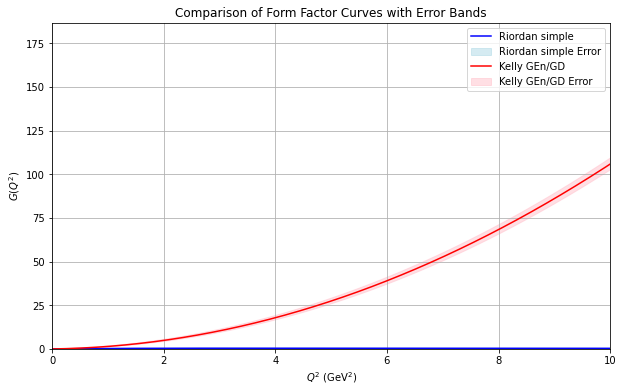

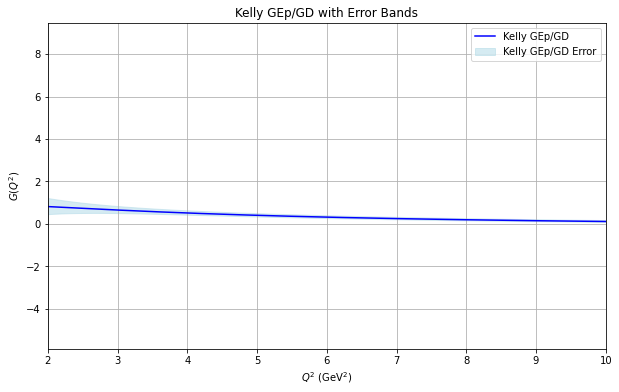

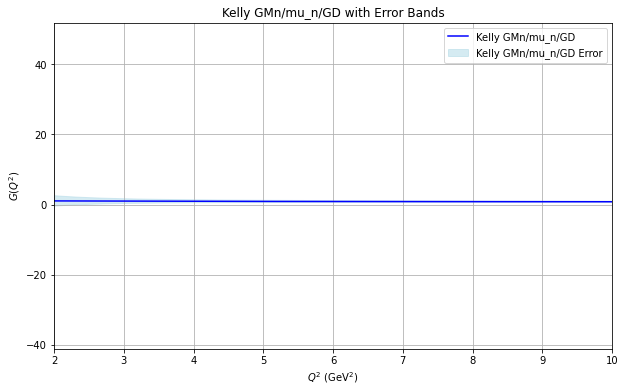

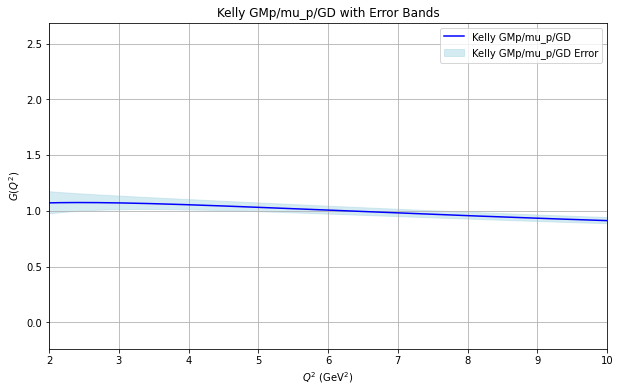

In [123]:
plot_curves(GEn_curve_data)
plot_single_curve([GEp_curve_data])
plot_single_curve([GMn_curve_data])
plot_single_curve([GMp_curve_data])

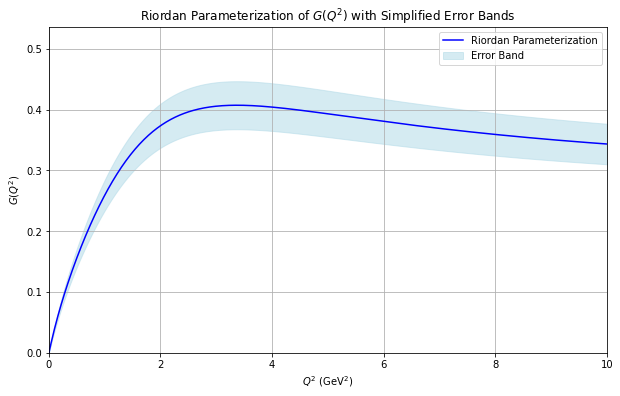

In [29]:
# Assuming rior_err_fac has been defined

# Use the riordan_parameterization function to calculate G(Q^2)
G_values = [riordan_parameterization(tau(Q2,M_n), riordan_params['a_coeffs'], riordan_params['b_coeffs']) for Q2 in Q2_values]

# Calculate the error bands using the simplified function
upper_bands = []
lower_bands = []
for G in G_values:
    upper_band, lower_band = simplified_riordan_error(G, rior_err_fac)
    upper_bands.append(upper_band)
    lower_bands.append(lower_band)

# Convert lists to numpy arrays for plotting
upper_bands = np.array(upper_bands)
lower_bands = np.array(lower_bands)

# Plot the curve and error bands
plt.figure(figsize=(10, 6))
plt.plot(Q2_values, G_values, label='Riordan Parameterization', color='blue')
plt.fill_between(Q2_values, lower_bands, upper_bands, color='lightblue', alpha=0.5, label='Error Band')
plt.xlabel('$Q^2$ (GeV$^2$)')
plt.ylabel('$G(Q^2)$')
plt.title('Riordan Parameterization of $G(Q^2)$ with Simplified Error Bands')
plt.xlim(0, 10)
plt.ylim(min(lower_bands), max(upper_bands)*1.2)
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Calculate the parameterization and error for each tau_p
G_values = []
G_errors = []

# Generate Q^2 values from 0 to 10
Q2_values = np.linspace(0, 10, 500)  # 500 points between 0 and 10

# Calculate tau_p values for each Q^2
tau_p_values = tau(Q2_values, M_p)

for tau_p in tau_p_values:
    G = riordan_parameterization(tau_p, riordan_params['a_coeffs'], riordan_params['b_coeffs'])
    one_sig_err = riordan_error(tau_p, riordan_params['a_coeffs'], riordan_params['a_err'], riordan_params['b_coeffs'], riordan_params['b_err'])
    G_values.append(G)
    G_errors.append(one_sig_err)

# Convert lists to NumPy arrays for easier manipulation
G_values = np.array(G_values)
G_errors = np.array(G_errors)

# Calculate the upper and lower bands
upper_band = G_values + G_errors
lower_band = G_values - G_errors

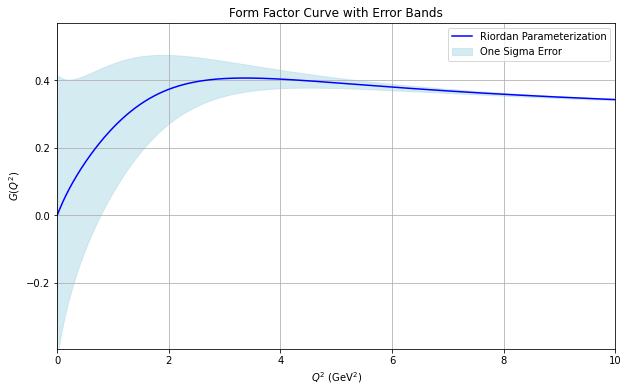

In [16]:
# Plots

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameterization curve
plt.plot(Q2_values, G_values, label='Riordan Parameterization', color='blue')

# Plot the error bands
plt.fill_between(Q2_values, lower_band, upper_band, color='lightblue', alpha=0.5, label='One Sigma Error')

# Set the labels, title, and legend
plt.xlabel('$Q^2$ (GeV$^2$)')
plt.ylabel('$G(Q^2)$')
plt.title('Form Factor Curve with Error Bands')
plt.xlim(0, 10)
plt.ylim(min(lower_band), max(upper_band)*1.2)
plt.legend()
plt.grid(True)
plt.show()